# 第六课 - Pandas进阶

本课内容：
* 数据的分组和聚合
 * pandas groupby 方法
 * pandas agg 方法
 * pandas apply 方法
* 案例讲解
 * 鸢尾花案例
 * 婴儿姓名案例
 * 餐馆小费案例

## 数据的分组&聚合 -- 什么是groupby 技术?
* 在数据分析中，我们往往需要在将数据拆分，在每一个特定的组里进行运算。比如根据教育水平和年龄段计算某个城市的工作人口的平均收入。
* pandas中的groupby提供了一个高效的数据的分组运算。
* 我们通过一个或者多个分类变量将数据拆分，然后分别在拆分以后的数据上进行需要的计算
* 我们可以把上述过程理解为三部：1.拆分数据（split） 2.应用某个函数（apply） 3.汇总计算结果（aggregate）
* 下面这个演示图展示了“分拆-应用-汇总”的groupby思想

<img src="L6.png">

## 案例1： 让我们来回顾下经典的iris数据
* 鸢尾花卉数据集，来源 [UCI 机器学习数据集](http://archive.ics.uci.edu/ml/datasets/Iris)
* 四个特征被用作样本的定量分析，它们分别是花萼(sepal)和花瓣(petal)的长度(length)和宽度(width)

<img src="iris.jpeg">

In [1]:
# 导入 pandas 包
import pandas as pd

# 导入鸢尾花数据
iris = pd.read_csv('iris.txt')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
# 统计每个品种的数据量
iris.species.value_counts()

Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: species, dtype: int64

### 1.1 分组运算 groupby 方法 -- 使用内置函数

鸢尾花数据中包括了3个不同的品种150个观测对象，数据分析中我们往往对一个品种的特性更感兴趣而不是每一个个体的数据描述。
假如一个植物园管理员提出这个问题：

**按品种划分，每个品种的花萼，花瓣的长度和宽度的最大值分别是多少？**

我们应该如何回答？


使用上述groupby的思想，我们可以将数据划分为3个小块，每个小块包含50个观测数据。然后使用max函数得到各个测量值的最大值，然后进行汇总。

In [3]:
iris.groupby('species').max()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
Iris-setosa,5.8,4.4,1.9,0.6
Iris-versicolor,7.0,3.4,5.1,1.8
Iris-virginica,7.9,3.8,6.9,2.5


In [4]:
# 我们可以size方法查看每个group的大小
iris.groupby('species').size()

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

### 1.2  使用自定义函数进行聚合运算 -- agg 方法
* 当计算变得复杂时，内置函数可能无法处理
* 我们需要自定义一个函数来进行计算, 传入一个数组做参数，返回一个标量的结果。
* groupby对象的agg/aggregate方法可以实现上述功能。

**计算每个品种所有属性（花瓣、花萼的长度和宽度）数值的跨度范围，即最大值减去最小值**

In [5]:
# 首先自定义一个函数
def range_iris(arr):
    return arr.max() - arr.min()

In [6]:
# 可以使用agg或者aggregate（两者等价）
iris.groupby('species').agg(range_iris)

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
Iris-setosa,1.5,2.1,0.9,0.5
Iris-versicolor,2.1,1.4,2.1,0.8
Iris-virginica,3.0,1.6,2.4,1.1


In [7]:
# 我们还可以同时应用多个函数，将函数名字放入一个列表即可，内置函数名需要用引号
iris.groupby('species').agg(['mean','max',range_iris])

sepal_length                 sepal_width                  \
                        mean  max range_iris        mean  max range_iris   
species                                                                    
Iris-setosa            5.006  5.8        1.5       3.418  4.4        2.1   
Iris-versicolor        5.936  7.0        2.1       2.770  3.4        1.4   
Iris-virginica         6.588  7.9        3.0       2.974  3.8        1.6   

                petal_length                 petal_width                  
                        mean  max range_iris        mean  max range_iris  
species                                                                   
Iris-setosa            1.464  1.9        0.9       0.244  0.6        0.5  
Iris-versicolor        4.260  5.1        2.1       1.326  1.8        0.8  
Iris-virginica         5.552  6.9        2.4       2.026  2.5        1.1

In [8]:
# 针对不同的列，应用不同的聚合函数
iris.groupby('species').agg({'petal_width': ['min'],
                            'petal_length': [range_iris]})

,petal_width,petal_length
,min,range_iris
species,,
Iris-setosa,0.1,0.9
Iris-versicolor,1.0,2.1
Iris-virginica,1.4,2.4


### 1.3 更广泛的分组运算 --  apply方法
* agg 方法将一个函数使用在一个数列上，然后返回一个标量的值。
* apply 是一个更一般化的方法：将一个数据分拆-应用-汇总

**提取每个品种前n个观测值作为一个样本**

In [9]:
# 可以定义函数：返回一个DataFrame的前n个值
def first_n(df, n = 3):
    return(df[0:n])

In [10]:
# 如果提取的样本数n>1, 则不能使用agg方法，因为agg方法必须生成一个标量数值，所以这里会出错
iris.groupby("species").agg(first_n)

ValueError: cannot copy sequence with size 5 to array axis with dimension 3

In [ ]:
# 所以必须考虑更一般化的apply方法
# 注意：n是参数，我们可以直接在函数名称后加上需要的参数
iris.groupby("species").apply(first_n, n = 4)

## 阶段小结：
* 我们主要讲了如何将数据根据某些条件分拆为几个子数据，然后在每个子数据上进行计算从而得到所要的结果。 
* 主要思想是分拆-应用-汇总。
* 对于一些简单的计算，比如最大值最小值的计算，我们可以直接使用groupby之后采用相应的内置方法。
* 对于一些更为复杂的计算，我们需要自己定义函数然后应用到拆分后的子数据上。根据具体要求来决定使用agg方法还是apply方法。 

## 作业6-1：
1. 计算每个品种鸢尾花各个属性（花萼、花瓣的长度和宽度）的最小值、平均值又是分别是多少？
（*提示：使用min、mean 方法。*）

2. 计算鸢尾花每个品种的花萼长度（sepal_length) 大于6cm的数据个数。

## 案例2：美国婴儿名字数据
* 数据来源： https://www.ssa.gov/oact/babynames/limits.html
* 包括1880至2016所有年份出生的婴儿名。


In [11]:
# 读取数据，其中我们使用上节课讲到的read_csv函数，以及第二节课讲到的循环

years = range(1880, 2017)  # 从1880年到2016年
pieces = []  # 初始化一个列表来储存每一年的数据
columns = ['name', 'gender', 'frequency']  # 设置每一列的名称

# 文件名的规律是yob + 年份，所以可以使用循环读取每一年的数据
for year in years:  
    path = 'names/yob%d.txt' % year  
    frame = pd.read_csv(path, names=columns)  
    frame['year'] = year  
    pieces.append(frame)
    
# 最后使用concat方法将pieces列表中所有的DataFrame整合在一起
baby_names = pd.concat(pieces, ignore_index=True)  

In [12]:
baby_names.head()

,name,gender,frequency,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [ ]:
# 大约有190万行数据，占内存57.7M，你觉得数据量大吗？
baby_names.info()

In [ ]:
# 根据多个属性来分组数据，比如根据年代和性别分组，计算每组数据的大小
baby_names.groupby(['year', 'gender']).size()

### **在不同的年份不同性别中，计算每个名字所占的百分比**

In [19]:
def add_pct(group):
    # 定义一个新的变量pct，使用series向量化计算 （第四节课概念）
    group['pct'] = group.frequency / group.frequency.sum() * 100
    return group

# 使用本节课讲解的groupby和apply函数 
baby_names = baby_names.groupby(['year', 'gender']).apply(add_pct) 

baby_names.head()

,name,gender,frequency,year,pct
0,Mary,F,7065,1880,7.764419
1,Anna,F,2604,1880,2.861790
2,Emma,F,2003,1880,2.201292
3,Elizabeth,F,1939,1880,2.130957
4,Minnie,F,1746,1880,1.918850


In [20]:
# 我们可以自己增加一个变量rank，这个是根据年份性别依据名字出现频率所产生的次序
# ascending=False指定排序由大到小，即最高频率获得rank 1 
baby_names['ranked'] = baby_names.groupby(['year', 'gender'])['frequency'].rank(ascending=False)

baby_names.head()

,name,gender,frequency,year,pct,ranked
0,Mary,F,7065,1880,7.764419,1.0
1,Anna,F,2604,1880,2.861790,2.0
2,Emma,F,2003,1880,2.201292,3.0
3,Elizabeth,F,1939,1880,2.130957,4.0
4,Minnie,F,1746,1880,1.918850,5.0


### **每年最流行的男孩女孩名字所占的百分比变化趋势如何？**
* 思路：可以使用matlibplot画出rank1的男孩女孩的名字每年所占总人数的百分比

#### **使用Matplotlib工具绘图**

下面的线图（line plot）由matlibplot实现，我们可以逐渐添加比如图标题，x轴和y轴的标签等等使图形更加美观

In [22]:
# 导入Matplotlib做图工具
import matplotlib.pyplot as plt

# 设置在notebook中直接展示图形输出
%matplotlib inline 

# 设置图片清晰度
%config InlineBackend.figure_format = 'retina'

In [23]:
# 首先通过上节课讲到的布尔索引将数据分为男孩和女孩
dfm = baby_names[baby_names.gender == 'M']
dff = baby_names[baby_names.gender == 'F'] 

In [24]:
# 获取每年最流行的男孩姓名
rank1m = dfm[dfm.ranked == 1]
rank1m

,name,gender,frequency,year,pct,ranked
942,John,M,9655,1880,8.738268,1.0
2938,John,M,8769,1881,8.704327,1.0
4963,John,M,9557,1882,8.406488,1.0
7116,John,M,8894,1883,8.500674,1.0
9318,John,M,9388,1884,8.203210,1.0
11640,John,M,8756,1885,8.122524,1.0
14019,John,M,9026,1886,8.147386,1.0
16435,John,M,8110,1887,7.996845,1.0
18976,John,M,9247,1888,7.651571,1.0
21632,John,M,8548,1889,7.730080,1.0


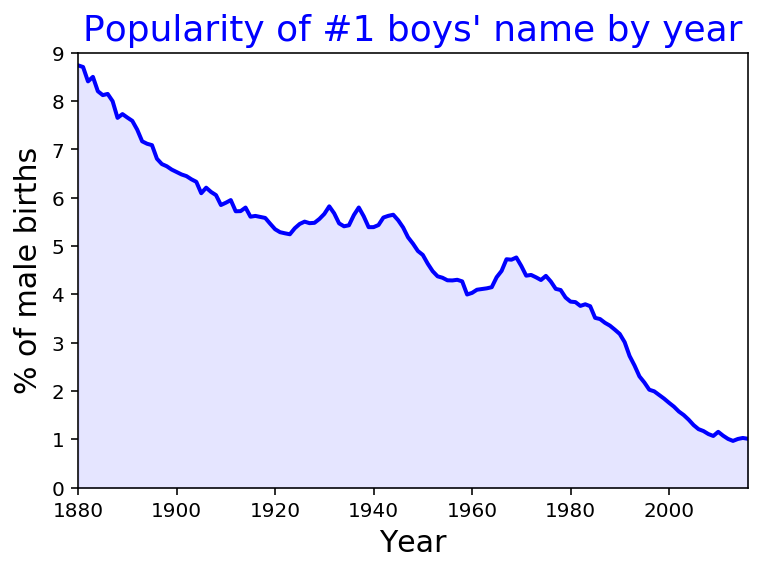

In [25]:
# 绘制折线图
plt.plot(rank1m.year, rank1m.pct, color="blue", linewidth = 2)
# fill_between填充了线和x轴之间的空间，alpha调整透明度（alpha越大越不透明）
plt.fill_between(rank1m.year, rank1m.pct, color="blue", alpha = 0.1)
# 设置坐标区间范围
plt.xlim(1880,2016)
plt.ylim(0,9)
# 添加标题，字体大小由size调整，颜色由color调整
plt.title("Popularity of #1 boys' name by year", size=18, color="blue")
plt.xlabel('Year', size=15)
plt.ylabel('% of male births', size=15)

In [27]:
# 获取每年最流行的女孩姓名
rank1f = dff[dff.ranked == 1]
rank1f

,name,gender,frequency,year,pct,ranked
0,Mary,F,7065,1880,7.764419,1.0
2000,Mary,F,6919,1881,7.524496,1.0
3935,Mary,F,8148,1882,7.555148,1.0
6062,Mary,F,8012,1883,7.133318,1.0
8146,Mary,F,9217,1884,7.143854,1.0
10443,Mary,F,9128,1885,6.860321,1.0
12737,Mary,F,9889,1886,6.842036,1.0
15129,Mary,F,9888,1887,6.773484,1.0
17502,Mary,F,11754,1888,6.580303,1.0
20153,Mary,F,11648,1889,6.530393,1.0


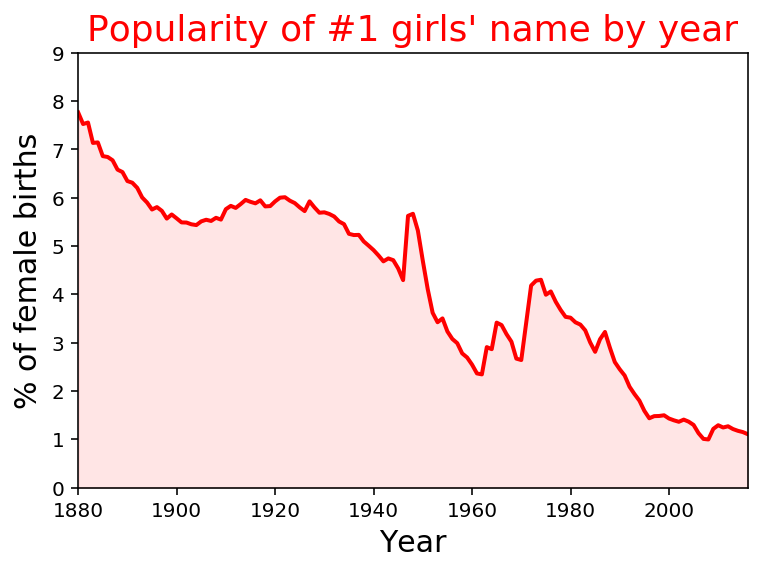

In [28]:
# 下面用同样的思路画出女孩的名字趋势图
plt.plot(rank1f.year, rank1f.pct, color="red", linewidth = 2)
plt.fill_between(rank1f.year, rank1f.pct, color="red", alpha = 0.1)
plt.xlim(1880,2016)
plt.ylim(0,9)
plt.title("Popularity of #1 girls' name by year", size=18, color="red")
plt.xlabel('Year', size=15)
plt.ylabel('% of female births', size=15)

### **为什么历史上最流行的男孩女孩名字所占的比重逐年降低?**

In [29]:
# 查看每年可选的名字，按性别分类
# size方法返回一个series
name_count = baby_names.groupby(['year', 'gender']).size() 
# 使用to_frame 将series转换为DataFrame
# reset_index将year和gender作为两个变量而非索引
name_count = name_count.to_frame(name="name_count").reset_index()       

In [30]:
name_count.head()

,year,gender,name_count
0,1880,F,942
1,1880,M,1058
2,1881,F,938
3,1881,M,997
4,1882,F,1028


In [ ]:
# 和上面最流行名字比重类似，我们来画出每年可选名字个数的图

# 获取男孩的数据
name_count_m = name_count[name_count.gender == "M"]
# 绘制折线图
plt.plot(name_count_m.year, name_count_m.name_count, color="blue", linewidth = 2)
# 填充颜色
plt.fill_between(name_count_m.year, name_count_m.name_count, color="blue", alpha = 0.1)
# 设置左边区间范围
plt.xlim(1880,2016)
plt.ylim(0,21000)
# 添加标题，字体大小由size调整，颜色由color调整
plt.title("Number of boy's names by year", size=18, color="blue")
plt.xlabel('Year', size=15)
plt.ylabel('Number of names', size=15)

In [ ]:
# 对应的女孩名字
name_count_f = name_count[name_count.gender == "F"]
plt.plot(name_count_f.year, name_count_f.name_count, color="red", linewidth = 2)
plt.fill_between(name_count_f.year, name_count_f.name_count, color="red", alpha = 0.1)
plt.xlim(1880,2016)
plt.ylim(0,21000)
plt.title("Number of girl's names by year", size=18, color="red")
plt.xlabel('Year', size=15)
plt.ylabel('Number of names', size=15)

### **结论：可选择的名字逐年增加，所以流行名字的占比逐年降低**
从数据中快速看到一个现象是我们学习数据分析的一个必要技能，让数据告诉我们发生的现象。



## 作业6-2：
分别找出2015, 2016年最流行的前10个男孩和女孩名字, 想给自己起一个流行的英文名字的可以行动起来了。

提示：使用groupby().apply()
* 思路一，使用ranked这一列， 取其值小于等于10的数据
* 思路二，使用pct这一列，用sort_values方法对其排列大小，取最大的10行数据

In [31]:
# sort_vlaues() 的使用方法
# 比如我们想知到iris数据中花瓣长度最大的前10个观测值
# 因为sort_values是从小到大排列，所以可以使用-10:表示取倒数10个。
iris.sort_values(by = "petal_length")[-10:]

,sepal_length,sepal_width,petal_length,petal_width,species
125,7.2,3.2,6.0,1.8,Iris-virginica
130,7.4,2.8,6.1,1.9,Iris-virginica
135,7.7,3.0,6.1,2.3,Iris-virginica
109,7.2,3.6,6.1,2.5,Iris-virginica
107,7.3,2.9,6.3,1.8,Iris-virginica
131,7.9,3.8,6.4,2.0,Iris-virginica
105,7.6,3.0,6.6,2.1,Iris-virginica
117,7.7,3.8,6.7,2.2,Iris-virginica
122,7.7,2.8,6.7,2.0,Iris-virginica
118,7.7,2.6,6.9,2.3,Iris-virginica


## 案例3：餐馆小费数据
* 小费，指给予服务生消费额以外的赏钱，在美国餐馆用餐完后通常会给服务生15-20%的小费。
* 这个数据是由Bryant和Smith于1995年所著的商务统计上的一个数据

In [32]:
# 读取csv数据文件
tips = pd.read_csv('tips.csv')

In [33]:
# total_bill：账单总额
# tip: 所付小费
# sex: 性别
# smoker：是否吸烟
# day：周一至周日的一天
# time：晚餐(dinner)还是午餐(lunch)
# size: 用餐人数
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### ** 什么因素会影响小费比例？**
* 一个优秀的数据分析员一定是一个可以提出有意义问题的人
* 好的数据分析员往往可以根据商业背景提出一些假说，然后通过数据来验证这些假说 


In [34]:
# 第一步：计算小费比例
tips["tip_pct"] = tips["tip"] / tips["total_bill"] # 向量化计算
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


* ** 性别是不是决定小费的要素？**

In [35]:
# std: 是标准差，一个衡量数据波动大小的统计量，简单来说越大表示数据波动越大
tips.groupby("sex")["tip_pct"].agg(["mean", "max", "min", "std"])

,mean,max,min,std
sex,,,,
Female,0.166491,0.416667,0.056433,0.053632
Male,0.157651,0.710345,0.035638,0.064778


* **将数据进一步细分，除了性别，是否和吸烟有关？**

In [36]:
# 女性吸烟者给的小费百分比最高
tips.groupby(["sex", "smoker"])["tip_pct"].agg(["mean", "max", "min", "std"])

mean       max       min       std
sex    smoker                                        
Female No      0.156921  0.252672  0.056797  0.036421
       Yes     0.182150  0.416667  0.056433  0.071595
Male   No      0.160669  0.291990  0.071804  0.041849
       Yes     0.152771  0.710345  0.035638  0.090588

* **晚上小费会不会更多？**

In [ ]:
tips.groupby(["sex", "time"])["tip_pct"].agg(["mean", "max", "min", "std"])

* **周末是否小费更多？**

In [ ]:
# 统计一周中不同天的账单数
tips["day"].value_counts()

In [ ]:
# 增加一个标量weekend表示是不是周末
tips["weekend"] = tips["day"].isin(["Sat","Sun"])
tips.head()

In [ ]:
tips.groupby(["sex", "weekend"])["tip_pct"].agg(["mean", "max", "min", "std"])

## 作业6-3：
1. 找出一周中哪一天，平均小费百分比最高。
2. 根据性别和用餐人数查看小费百分比的均值和每组的数据个数(count)。